In [2]:
!git --version

git version 2.17.1


# 필요패키지 import

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torchvision.utils import make_grid

# GPU or CPU

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


# MNIST Data 불러오기

In [3]:
mnist_train = dsets.MNIST(root="MNIST_data/", 
                          train = True, 
                          transform = transforms.ToTensor(), 
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform = transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



# Data 확인

In [4]:
# train data 하나 확인(이미지 텐서 값과 레이블 값으로 구성)
mnist_train[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
img, label = mnist_train[0]
print(img.shape)
print(label)

torch.Size([1, 28, 28])
5


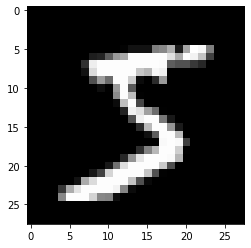

In [6]:
plt.imshow(img.reshape(28, 28), cmap="gray")

# 하이퍼파라미터 설정

In [7]:
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 0.01

# DataLoader

In [8]:
train_loader = DataLoader(dataset=mnist_train,
                          batch_size =64, 
                          shuffle=True)


test_loader = DataLoader(dataset=mnist_test,
                         batch_size=64, 
                         shuffle=False)

In [9]:
def show_batch(dl):
    for batch in dl:
        images,labels = batch
        fig, ax = plt.subplots(figsize=(7.5,7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:20],nrow=5).permute(1,2,0))
        break

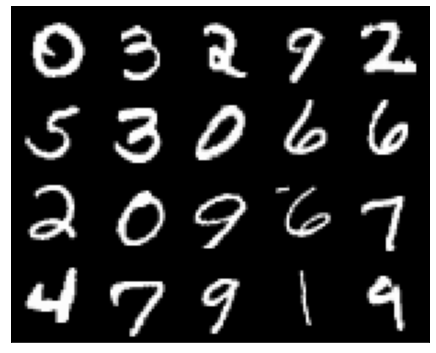

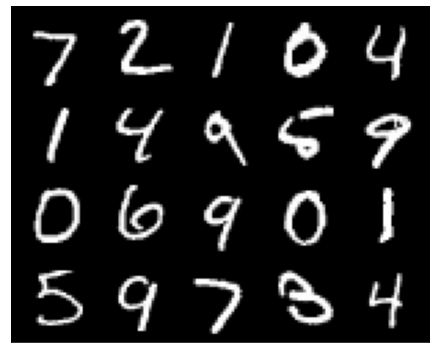

In [10]:
show_batch(train_loader)
show_batch(test_loader)

# 모델 설계(CNN)

##model1

In [11]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    # MaxPooling2의 결과 : channel=64, output=7*7
    self.fc = nn.Linear(7*7*64, 10, bias = True)
    # fc layer 초기화
    torch.nn.init.xavier_uniform_(self.fc.weight)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)

    out = out.view(out.size(0),-1)
    out = self.fc(out)
    return out

In [12]:
net = CNN().to(device)
net

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

## model2

In [22]:
class CNN2(nn.Module):

  def __init__(self):
    super(CNN2, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.layer5 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )


    self.fc1 = nn.Sequential(
        nn.Linear(512*7*7, 512),
        nn.ReLU()
    )

    self.fc2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU()
    )
    
    self.fc3 = nn.Linear(256, 10, bias = True)

#    torch.nn.init.xavier_uniform_(self.fc1.weight)
#    torch.nn.init.xavier_uniform_(self.fc2.weight)
#    torch.nn.init.xavier_uniform_(self.fc3.weight)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)


    out = out.view(out.size(0),-1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [23]:
net2 = CNN2().to(device)
net2

CNN2(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=25088, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_

# loss function & optimizer

In [15]:
# 비용함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음
optimizer = torch.optim.Adam(net2.parameters(),lr=0.01)

# Train & Test 함수 정의

In [16]:
def train(model, train_loader, optimizer, epoch, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data = data.to(device)
      target = target.to(device)

      optimizer.zero_grad()

      output = model(data)

      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      if batch_idx % 200 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.
              format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))

In [17]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
          data = data.to(device)
          target = target.to(device)

          output = model(data)

          test_loss += criterion(output, target).item()
          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
          format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

# epoch별 Train & Test 확인

### CNN

In [31]:
# 모델 돌릴때마다 같이 돌려줘야 model.parameters()값이 초기화됨
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음
optimizer = torch.optim.Adam(net.parameters(),lr=0.01)

In [19]:
for epoch in range(1, 11):
    train(net, train_loader, optimizer, epoch, criterion)
    test(net, test_loader, criterion)
#torch.save(model, './model.pt')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317629
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.239807
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.015726
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.169632
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.191243

Test set: Average loss: 0.0009, Accuracy: 9831/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.096904
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.122951
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.027152
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.069087
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.070866

Test set: Average loss: 0.0010, Accuracy: 9783/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.037059
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.129580
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.011828
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.019126
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.021470

Test set: Average loss: 0.0008, Accuracy: 9830/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.058179
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [32]:
for epoch in range(11, 51):
    train(net, train_loader, optimizer, epoch, criterion)
    test(net, test_loader, criterion)
#torch.save(model, './model.pt')

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.001628
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.203026
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.094793
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.040654
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.123343

Test set: Average loss: 0.0013, Accuracy: 9833/10000 (98%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.000040
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.046928
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.193949
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.108949
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.005748

Test set: Average loss: 0.0014, Accuracy: 9824/10000 (98%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.003982
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.143468
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.001975
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.018893
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.038574

Test set: Average loss: 0.0013, Accuracy: 9864/10000 (99%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.009432
Train Epoch: 14 [1280

### CNN

In [24]:
# 모델 돌릴때마다 같이 돌려줘야 model.parameters()값이 초기화됨
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음
optimizer = torch.optim.Adam(net2.parameters(),lr=0.01)

In [25]:
for epoch in range(1, 11):
    train(net2, train_loader, optimizer, epoch, criterion)
    test(net2, test_loader, criterion)
#torch.save(model, './model.pt')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297903
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.297762
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.392733
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.104619
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.217212

Test set: Average loss: 0.0014, Accuracy: 9724/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.096894
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.025156
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.212862
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.113932
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.051902

Test set: Average loss: 0.0016, Accuracy: 9716/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.070394
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.159484
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.011958
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.012999
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.102755

Test set: Average loss: 0.0019, Accuracy: 9675/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.113220
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [27]:
for epoch in range(11, 31):
    train(net2, train_loader, optimizer, epoch, criterion)
    test(net2, test_loader, criterion)
#torch.save(model, './model.pt')

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.005134
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.091627
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.117489
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.116006
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.027679

Test set: Average loss: 0.0013, Accuracy: 9808/10000 (98%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.243306
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.069003
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.010788
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.218987
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.151771

Test set: Average loss: 0.0021, Accuracy: 9733/10000 (97%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.040399
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.097478
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.176698
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.094085
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.021486

Test set: Average loss: 0.0012, Accuracy: 9843/10000 (98%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.059252
Train Epoch: 14 [1280

In [29]:
for epoch in range(31, 51):
    train(net2, train_loader, optimizer, epoch, criterion)
    test(net2, test_loader, criterion)
#torch.save(model, './model.pt')

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.053796
Train Epoch: 31 [12800/60000 (21%)]	Loss: 0.099072
Train Epoch: 31 [25600/60000 (43%)]	Loss: 0.169385
Train Epoch: 31 [38400/60000 (64%)]	Loss: 0.047942
Train Epoch: 31 [51200/60000 (85%)]	Loss: 0.114893

Test set: Average loss: 0.0017, Accuracy: 9800/10000 (98%)

Train Epoch: 32 [0/60000 (0%)]	Loss: 0.039903
Train Epoch: 32 [12800/60000 (21%)]	Loss: 0.017059
Train Epoch: 32 [25600/60000 (43%)]	Loss: 0.088001
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.048455
Train Epoch: 32 [51200/60000 (85%)]	Loss: 0.130972

Test set: Average loss: 0.0014, Accuracy: 9813/10000 (98%)

Train Epoch: 33 [0/60000 (0%)]	Loss: 0.014865
Train Epoch: 33 [12800/60000 (21%)]	Loss: 0.003751
Train Epoch: 33 [25600/60000 (43%)]	Loss: 0.010155
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.244817
Train Epoch: 33 [51200/60000 (85%)]	Loss: 0.007691

Test set: Average loss: 0.0015, Accuracy: 9797/10000 (98%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.005084
Train Epoch: 34 [1280

# Test + 시각화

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy:  0.6764999628067017
Label: 1
Prediction:  5


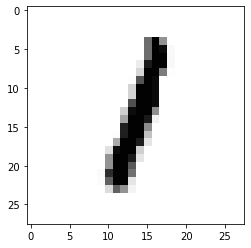

In [35]:
with torch.no_grad():

    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = net(X_test)
  # Y_test와 prediction 값이 같은지 비교
    correct_prediction = torch.argmax(prediction, 1) == Y_test
  # 평균 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy: ', accuracy.item())


######시각화(visualization)######
r = random.randint(0, len(mnist_test)-1)

X_single_data = mnist_test.test_data[r:r+1].view(1, 1, 28, 28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r+1].to(device)

print('Label:', Y_single_data.item())

single_prediction = net(X_single_data)
print("Prediction: ", torch.argmax(single_prediction, 1).item())

plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy:  0.9404000043869019
Label: 6
Prediction:  6


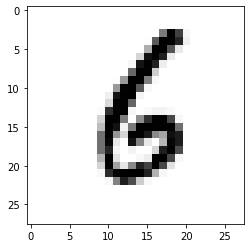

In [30]:
with torch.no_grad():

    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = net2(X_test)
  # Y_test와 prediction 값이 같은지 비교
    correct_prediction = torch.argmax(prediction, 1) == Y_test
  # 평균 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy: ', accuracy.item())


######시각화(visualization)######
r = random.randint(0, len(mnist_test)-1)

X_single_data = mnist_test.test_data[r:r+1].view(1, 1, 28, 28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r+1].to(device)

print('Label:', Y_single_data.item())

single_prediction = net2(X_single_data)
print("Prediction: ", torch.argmax(single_prediction, 1).item())

plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()
